In [1]:
# THIS CELL SETS STUFF UP FOR DEMO / COLLAB. THIS CELL CAN BE IGNORED.

#-------------------------------------GET RID OF TF DEPRECATION WARNINGS--------------------------------------#
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#----------------------------------INSTALL PSYCHRNN IF IN A COLAB NOTEBOOK-------------------------------------#
# Installs the correct branch / release version based on the URL. If no branch is provided, loads from master.
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    import json
    import re
    import ipykernel
    import requests 
    from requests.compat import urljoin

    from notebook.notebookapp import list_running_servers
    kernel_id = re.search('kernel-(.*).json',
                          ipykernel.connect.get_connection_file()).group(1)
    servers = list_running_servers()
    for ss in servers:
        response = requests.get(urljoin(ss['url'], 'api/sessions'),
                                params={'token': ss.get('token', '')})
        for nn in json.loads(response.text):
            if nn['kernel']['id'] == kernel_id:
                relative_path = nn['notebook']['path'].split('%2F')
                if 'blob' in relative_path:
                  blob = relative_path[relative_path.index('blob') + 1]
                  !pip install git+https://github.com/murraylab/PsychRNN@$blob
                else:
                  !pip install git+https://github.com/murraylab/PsychRNN

# Biological Constraints

The default RNN network has all to all connectivity, and allows units to have both excitatory and inhibitory connections. However, this does not reflect the biology we know. PsychRNN includes a framework for easily specifying biological constraints on the model. 

This example will introduce the different options for biological constraints included in PsychRNN:
- Dale Ratio
- Autapses
- Connectivity
- Fixed Weights

In [2]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline

# ---------------------- Import the package ---------------------------
from psychrnn.tasks.perceptual_discrimination import PerceptualDiscrimination
from psychrnn.backend.models.basic import Basic

# ---------------------- Set up a basic model ---------------------------
pd = PerceptualDiscrimination(dt = 10, tau = 100, T = 2000, N_batch = 128)
network_params = pd.get_task_params() # get the params passed in and defined in pd
network_params['name'] = 'model' # name the model uniquely if running mult models in unison
network_params['N_rec'] = 50 # set the number of recurrent units in the model

# -------------------- Set up variables that will be useful later -------
N_in = network_params['N_in']
N_rec = network_params['N_rec']
N_out = network_params['N_out']

This function will plot the colormap of the weights

In [3]:
def plot_weights(weights, title=""):
    cmap = plt.set_cmap('RdBu_r')
    img = plt.matshow(weights, norm=Normalize(vmin=-.5, vmax=.5))
    plt.title(title)

    plt.colorbar()

## Biologically Unconstrained

In [4]:
basicModel = Basic(network_params) # instantiate a basic vanilla RNN we will compare to later on

<Figure size 432x288 with 0 Axes>

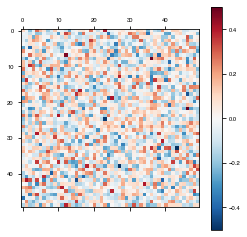

In [5]:
weights = basicModel.get_weights()
plot_weights(weights['W_rec'])

In [6]:
basicModel.destruct()

## Dale Ratio


Dale’s Principle states that a neuron releases the same set of neurotransmitters at each of its synapses ([Eccles et al., 1954](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1365877/pdf/jphysiol01404-0118.pdf)). Since neurotransmitters tend to be either excitatory or inhibitory, theorists have taken this to mean that each neuron has exclusively either excitatory or inhibitory synapses ([Song et al., 2016](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004792); [Rajan and Abbott, 2006](https://pubmed.ncbi.nlm.nih.gov/17155583/)). 

To set the dale ratio, simply set ``network_params['dale_ratio']`` equal to the proportion of total recurrent neurons that should be excitatory. The remainder will be inhibitory.

The dale ratio can be combined with any other parameter settings except for ``network_params['initializer']``, in which case the dale ratio needs to be passed directly into the [initializer](../apidoc/backend.rst#module-psychrnn.backend.initializations) being used. Dale ratio is not enforced if [LSTM](../apidoc/backend.rst#psychrnn.backend.models.lstm.LSTM) is used as the RNN imlementation.

Once the model is instantiated it can be trained and tested as demonstrated in [Simple Example](PerceptualDiscrimination.ipynb)

In [7]:
dale_network_params = network_params.copy()
dale_network_params['name'] = 'dales_model'
dale_network_params['dale_ratio'] = .8
daleModel = Basic(dale_network_params)

<Figure size 432x288 with 0 Axes>

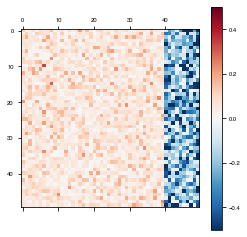

In [8]:
weights = daleModel.get_weights()
plot_weights(weights['W_rec'])

In [9]:
daleModel.destruct()

## Autapses

To disallow autapses (self connections) or not, simply set ``network_params['autapses'] = False``.

The autapses parameter can be combined with any other parameter settings except for ``network_params['initializer']``, in which case the boolean for autapses needs to be passed directly into the [initializer](../apidoc/backend.rst#module-psychrnn.backend.initializations) being used. Autapses are not enforced if [LSTM](../apidoc/backend.rst#psychrnn.backend.models.lstm.LSTM) is used as the RNN imlementation.

Once the model is instantiated it can be trained and tested as demonstrated in [Simple Example](PerceptualDiscrimination.ipynb)

In [10]:
autapses_network_params = network_params.copy()
autapses_network_params['name'] = 'autapses_model'
autapses_network_params['autapses'] = False
autapsesModel = Basic(autapses_network_params)

<Figure size 432x288 with 0 Axes>

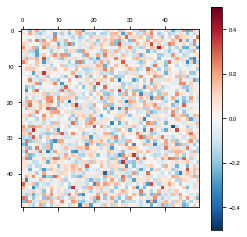

In [11]:
weights = autapsesModel.get_weights()
plot_weights(weights['W_rec'])

Notice the white line on the diagonal (self-connections) above, where the weights are 0.

In [12]:
autapsesModel.destruct()

## Connectivity

The brain is not all-to-all connected, so it can be useful to restrict and structure the connectivity of our RNNs.

The input_connectivity, recurrent_connectivity, and output_connectivity parameters allow us to do just that. Any subset of them can be combined with any other parameter settings except for ``network_params['initializer']``, in which case the connectivity matrices need to be passed directly into the [initializer](../apidoc/backend.rst#module-psychrnn.backend.initializations) being used. Connectivity is not enforced if [LSTM](../apidoc/backend.rst#psychrnn.backend.models.lstm.LSTM) is used as the RNN imlementation.

Once the model is instantiated it can be trained and tested as demonstrated in [Simple Example](PerceptualDiscrimination.ipynb)

In [13]:
modular_network_params = network_params.copy()
modular_network_params['name'] = 'modular_model'

# Set connectivity matrices to the default -- fully connected
input_connectivity = np.ones((N_rec, N_in)) 
rec_connectivity = np.ones((N_rec, N_rec)) 
output_connectivity = np.ones((N_out, N_rec)) 

# Specify certain connections to disallow. This can be done with input and output connectivity matrices as well
rec_connectivity[2*(N_rec//5):4*(N_rec//5),:2*(N_rec//5)] = 0
rec_connectivity[:2*(N_rec//5),2*(N_rec//5):4*(N_rec//5)] = 0

Plot the recurrent connectivity matrix

<Figure size 432x288 with 0 Axes>

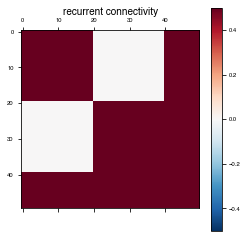

In [14]:
plot_weights(rec_connectivity, "recurrent connectivity")

Specify the connectivity matrices in ``network_params``. 

In [15]:
modular_network_params['input_connectivity'] = input_connectivity
modular_network_params['rec_connectivity'] = rec_connectivity
modular_network_params['output_connectivity'] = output_connectivity
modularModel = Basic(modular_network_params)

<Figure size 432x288 with 0 Axes>

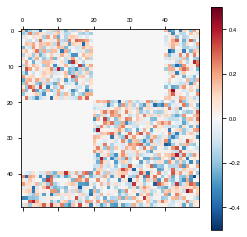

In [16]:
weights = modularModel.get_weights()

plot_weights(weights['W_rec'])

In [17]:
modularModel.destruct()

## Fixed Weights

Some parts of the brain we may assume to be less plastic than others. Alternatively, we may want to specify particular weights within the model and train the rest of them around those.

The fixed_weights parameter for the [train()](../apidoc/backend.rst#psychrnn.backend.rnn.RNN.train) fucntion allows us to do this.

Instantiate the model

In [18]:
fixed_network_params = network_params.copy()
fixed_network_params['name'] = 'fixed_model'
fixedModel = Basic(fixed_network_params) # instantiate a basic vanilla RNN we will compare to later on

Plot the model weights before training

<Figure size 432x288 with 0 Axes>

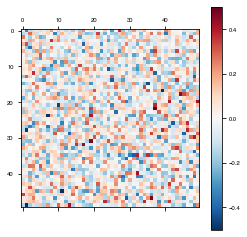

In [19]:
weights = fixedModel.get_weights()

plot_weights(weights['W_rec'])

In [20]:
# Set fixed weight matrices to the default -- fully trainable
W_in_fixed = np.zeros((N_rec,N_in))
W_rec_fixed = np.zeros((N_rec,N_rec))
W_out_fixed = np.zeros((N_out, N_rec))

# Specify certain weights to fix. 
W_rec_fixed[N_rec//5*4:, :4*N_rec//5] = 1
W_rec_fixed[:4*N_rec//5, N_rec//5*4:] = 1


# Specify the fixed weights parameters in train_params
train_params = {}
train_params['fixed_weights'] = {
    'W_in': W_in_fixed,
    'W_rec': W_rec_fixed,
    'W_out': W_out_fixed
}

In [21]:
losses, initialTime, trainTime = fixedModel.train(pd, train_params)

Iter 1280, Minibatch Loss= 0.177185
Iter 2560, Minibatch Loss= 0.107636
Iter 3840, Minibatch Loss= 0.099301
Iter 5120, Minibatch Loss= 0.085224
Iter 6400, Minibatch Loss= 0.082593
Iter 7680, Minibatch Loss= 0.079836
Iter 8960, Minibatch Loss= 0.080765
Iter 10240, Minibatch Loss= 0.079680
Iter 11520, Minibatch Loss= 0.072564
Iter 12800, Minibatch Loss= 0.067365
Iter 14080, Minibatch Loss= 0.040751
Iter 15360, Minibatch Loss= 0.052333
Iter 16640, Minibatch Loss= 0.046463
Iter 17920, Minibatch Loss= 0.031513
Iter 19200, Minibatch Loss= 0.033700
Iter 20480, Minibatch Loss= 0.033375
Iter 21760, Minibatch Loss= 0.035751
Iter 23040, Minibatch Loss= 0.041844
Iter 24320, Minibatch Loss= 0.038133
Iter 25600, Minibatch Loss= 0.023348
Iter 26880, Minibatch Loss= 0.027589
Iter 28160, Minibatch Loss= 0.019354
Iter 29440, Minibatch Loss= 0.022398
Iter 30720, Minibatch Loss= 0.020543
Iter 32000, Minibatch Loss= 0.013847
Iter 33280, Minibatch Loss= 0.017195
Iter 34560, Minibatch Loss= 0.019519
Iter 358

Plot the weights after training:

<Figure size 432x288 with 0 Axes>

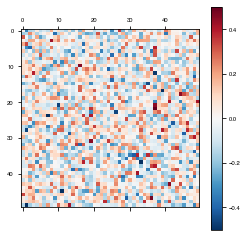

In [22]:
weights = fixedModel.get_weights()

plot_weights(weights['W_rec'])

In [23]:
fixedModel.destruct()

Unfortunately, it's hard to see visually whether the weights actually stayed fixed or not. To make it more apparent, we will set all of the fixed weights to the same value, the average of their previous value.

In [24]:
weights['W_rec'][N_rec//5*4:, :4*N_rec//5] = np.mean(weights['W_rec'][N_rec//5*4:, :4*N_rec//5])
weights['W_rec'][:4*N_rec//5, N_rec//5*4:] = np.mean(weights['W_rec'][:4*N_rec//5, N_rec//5*4:])

Now we make a new model loading the weights ``weights``

In [25]:
fixed_network_params = network_params.copy()
fixed_network_params['name'] = 'fixed_model_clearer'
for key, value in weights.items():
    fixed_network_params[key] = value
fixedModelClearer = Basic(fixed_network_params) # instantiate an RNN loading the revised weights from the previous model

Plot the model weights before training

<Figure size 432x288 with 0 Axes>

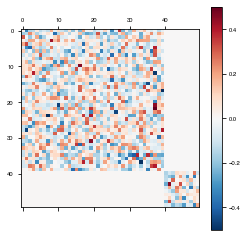

In [26]:
weights = fixedModelClearer.get_weights()

plot_weights(weights['W_rec'])

In [27]:
losses, initialTime, trainTime = fixedModelClearer.train(pd, train_params)

Iter 1280, Minibatch Loss= 0.050554
Iter 2560, Minibatch Loss= 0.024552
Iter 3840, Minibatch Loss= 0.021128
Iter 5120, Minibatch Loss= 0.028251
Iter 6400, Minibatch Loss= 0.019927
Iter 7680, Minibatch Loss= 0.016723
Iter 8960, Minibatch Loss= 0.013385
Iter 10240, Minibatch Loss= 0.016600
Iter 11520, Minibatch Loss= 0.020957
Iter 12800, Minibatch Loss= 0.012375
Iter 14080, Minibatch Loss= 0.019829
Iter 15360, Minibatch Loss= 0.020301
Iter 16640, Minibatch Loss= 0.019600
Iter 17920, Minibatch Loss= 0.017423
Iter 19200, Minibatch Loss= 0.010484
Iter 20480, Minibatch Loss= 0.014385
Iter 21760, Minibatch Loss= 0.017793
Iter 23040, Minibatch Loss= 0.009582
Iter 24320, Minibatch Loss= 0.014552
Iter 25600, Minibatch Loss= 0.010809
Iter 26880, Minibatch Loss= 0.012337
Iter 28160, Minibatch Loss= 0.017401
Iter 29440, Minibatch Loss= 0.012895
Iter 30720, Minibatch Loss= 0.016758
Iter 32000, Minibatch Loss= 0.011036
Iter 33280, Minibatch Loss= 0.007268
Iter 34560, Minibatch Loss= 0.008717
Iter 358

Plot the model weights after training. Now it is clear that the weights haven't changed.

<Figure size 432x288 with 0 Axes>

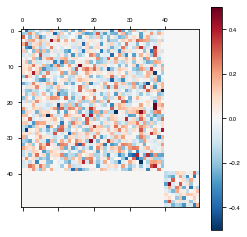

In [28]:
weights = fixedModelClearer.get_weights()

plot_weights(weights['W_rec'])

In [29]:
fixedModelClearer.destruct()